In [1]:
import pandas as pd
from torch import nn
import torch
from torchinfo import summary
import glob
from tqdm.notebook import tqdm
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn 
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose,Resize,RandomVerticalFlip,RandomHorizontalFlip,ColorJitter,ToTensor,Normalize, Lambda
from collections import OrderedDict
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from torchvision import models
import gc

In [2]:
model = models.segmentation.deeplabv3_resnet50(pretrained=False)
model.classifier[4] = torch.nn.Conv2d(256, 5, kernel_size=(1, 1), stride=(1, 1))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


In [3]:
#parameters
IMG_WIDTH=224
IMG_HEIGHT=224
BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_DEVICES = torch.cuda.device_count()
LR = 1e-4
PATIENCE=8
EPOCHS=10
PATH_TO_DATASET='/kaggle/input/lumbar-spine-mri'


In [4]:
def create_dataframe():
    #read path for images
    images_path=glob.glob(f'{PATH_TO_DATASET}/Resized_Composite_Images/Resized_Composite_Images/*.png')
    masks_path=glob.glob(f'{PATH_TO_DATASET}/Resized_Label_Images/Resized_Label_Images/*.png')
    print(f' length of masks path {len(masks_path)}, length of images path {len(images_path)}')
    data=pd.DataFrame(data={
        'mask path':masks_path,
        'image path':images_path
    })
    print(data.head())
    return data

In [5]:
def view_sample(index:int,data):
    path_img=data['image path'][index]
    path_mask=data['mask path'][index]
    print(f'Path for image {path_img}, path for mask {path_mask}')
    
    #3chart 1-img,2-mask,3-img+mask
    img=Image.open(path_img)
    img_array=np.array(img).astype(np.float32) / 255
    plt.subplot(1,3,1)
    plt.title(f'Image of brain')
    plt.imshow(img_array,cmap='mako')
    
    mask=Image.open(path_mask)
    mask_array=np.array(mask).astype(np.float32) / 255
    plt.subplot(1,3,2)
    plt.title(f'Mask')
    plt.imshow(mask_array,cmap='gray')
    
    plt.subplot(1,3,3)
    plt.imshow(img_array,cmap='mako')
    plt.title(f'Image of brain and mask ')
    plt.imshow(mask_array,cmap='gray',alpha=0.5)

 length of masks path 1545, length of images path 1545
                                           mask path  \
0  /kaggle/input/lumbar-spine-mri/Resized_Label_I...   
1  /kaggle/input/lumbar-spine-mri/Resized_Label_I...   
2  /kaggle/input/lumbar-spine-mri/Resized_Label_I...   
3  /kaggle/input/lumbar-spine-mri/Resized_Label_I...   
4  /kaggle/input/lumbar-spine-mri/Resized_Label_I...   

                                          image path  
0  /kaggle/input/lumbar-spine-mri/Resized_Composi...  
1  /kaggle/input/lumbar-spine-mri/Resized_Composi...  
2  /kaggle/input/lumbar-spine-mri/Resized_Composi...  
3  /kaggle/input/lumbar-spine-mri/Resized_Composi...  
4  /kaggle/input/lumbar-spine-mri/Resized_Composi...  
Path for image /kaggle/input/lumbar-spine-mri/Resized_Composite_Images/Resized_Composite_Images/0386_D5.png, path for mask /kaggle/input/lumbar-spine-mri/Resized_Label_Images/Resized_Label_Images/0386_D5.png


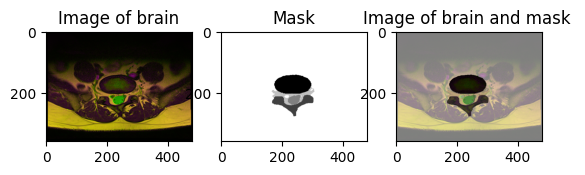

In [6]:
data=create_dataframe()
index=random.randint(0,100)
view_sample(index=index,data=data)

In [7]:
#Create training,validate,test sets
X_train, X_test, y_train, y_test = train_test_split(data.index,data.index, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2,random_state=42)

In [8]:
print(f'Train dataset {len(X_train)} {len(y_train)}, validate dataset {len(X_val)} {len(y_val)}, test dataset {len(X_test)} {len(y_test)}')

Train dataset 988 988, validate dataset 248 248, test dataset 309 309


In [9]:
def map_mask_to_class(mask):

    
    class_mask = np.zeros_like(mask, dtype=np.int64)

    class_mask = np.where(mask == 50, 0, class_mask)
    class_mask = np.where(mask == 100, 1, class_mask)
    class_mask = np.where(mask == 150, 2, class_mask)
    class_mask = np.where(mask == 200, 3, class_mask)
    class_mask = np.where(mask == 250, 4, class_mask)

    return class_mask
    
def preprocess_mask(mask):
    mask_array = np.array(mask)  # Konwertujemy maskę na numpy array
    class_mask = map_mask_to_class(mask_array)  # Mapowanie maski na klasy
    class_mask_tensor = torch.tensor(class_mask, dtype=torch.long)  # Konwersja do tensora torch
    return class_mask_tensor

preprocess_image = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [10]:
#create training DataFrame
images_test=[]
masks_test=[]
patients_id_test=[]
images_val=[]
masks_val=[]
patients_id_val=[]
images_train=[]
masks_train=[]
patients_id_train=[]

for idx in X_val:
    images_val.append(data['image path'][idx])
    masks_val.append(data['mask path'][idx])
    
for idx in X_train:
    images_train.append(data['image path'][idx])
    masks_train.append(data['mask path'][idx])

for idx in X_test:
    images_test.append(data['image path'][idx])
    masks_test.append(data['mask path'][idx])
    
data_train=pd.DataFrame(
data={
        'image path':images_train,
        'mask path':masks_train,
    })
data_val=pd.DataFrame(
data={
        'image path':images_val,
        'mask path':masks_val,
    })

data_test=pd.DataFrame(
data={
        'image path':images_test,
        'mask path':masks_test,
    })

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, data:pd.DataFrame,transform_image=None,transform_mask=None):
        self.images = data['image path'].to_list()
        self.masks = data['mask path'].to_list()
        self.transform_image = transform_image
        self.transform_mask = transform_mask
   
    def read_image(self,path:str):
        img=Image.open(path)
#         img_array=np.array(img).astype(np.float32) / 255
        return img

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]
        image = self.read_image(img_path)
        mask = self.read_image(mask_path)
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        return image,mask

In [12]:
train_datasets=CustomImageDataset(data=data_train,transform_image=preprocess_image,transform_mask=preprocess_mask)
validation_datasets=CustomImageDataset(data=data_val,transform_image=preprocess_image,transform_mask=preprocess_mask)
test_datasets=CustomImageDataset(data=data_test,transform_image=preprocess_image,transform_mask=preprocess_mask)

In [13]:
train_dataloader=DataLoader(train_datasets,batch_size=16,shuffle=True)
validation_dataloader=DataLoader(validation_datasets,batch_size=16)
test_dataloader=DataLoader(test_datasets,batch_size=16)

In [14]:
def train(model,dataloader:DataLoader,validate_dataloader:DataLoader,optmizer:torch.optim, loss_fn:nn.Module,device:torch.device):
    train_loss, train_dice = 0, 0
    class_dice_scores = {i: 0 for i in range(5)}
    for batch,(X,y) in enumerate(dataloader):
        model.train()
        X, y = X.to(device), y.to(device)
        #print(np.unique(np.array(y.cpu())))
        y_pred = model(X)
        y_pred = y_pred["out"]
        loss_fn = loss_fn.to(device)
        y = y.squeeze(1).long()
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        predicted_class = torch.argmax(y_pred, dim=1)  
        eps = 1e-8
        for i in range(5):  
            predicted_class_i = (predicted_class == i).float()
            y_i = (y == i).float()
            
            dice_score = (2 * (y_i * predicted_class_i).sum() + eps) / (y_i.sum() + predicted_class_i.sum() + eps)
            train_dice += dice_score.item()
            class_dice_scores[i] += dice_score.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    validate_loss, validate_dice,class_dice_avg_val=test(model,validate_dataloader,optimizer,loss_fn,device)
    train_loss = train_loss / len(dataloader)
    train_dice = train_dice / len(dataloader)
    class_dice_avg_train = {key: value / len(dataloader) for key, value in class_dice_scores.items()}
    
    return train_loss, train_dice, validate_loss, validate_dice,class_dice_avg_train,class_dice_avg_val

In [15]:
def test(model,dataloader:DataLoader,optmizer:torch.optim, loss_fn:nn.Module,device:torch.device):
    test_loss, test_dice = 0, 0
    model.eval()
    class_dice_scores = {i: 0 for i in range(5)} 
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred = y_pred["out"]
            loss_fn = loss_fn.to(device)
            y = y.squeeze(1).long()
            loss = loss_fn(y_pred, y)
            test_loss += loss.item() 
            predicted_class = torch.argmax(y_pred, dim=1)  
            eps = 1e-8
            for i in range(5): 
                predicted_class_i = (predicted_class == i).float()
                y_i = (y == i).float()

                dice_score = (2 * (y_i * predicted_class_i).sum() + eps) / (y_i.sum() + predicted_class_i.sum() + eps)
                test_dice += dice_score.item()
                class_dice_scores[i] += dice_score.item()


        test_loss = test_loss / len(dataloader)
        class_dice_avg = {key: value / len(dataloader) for key, value in class_dice_scores.items()}
        test_dice = test_dice / len(dataloader)
    
    return test_loss, test_dice,class_dice_avg

In [16]:
def run(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    validation_dataloader:torch.utils.data.DataLoader,
    test_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    scheduler:torch.optim.lr_scheduler,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device
   ):

    dice_train=[]
    dice_test=[]
    dice_val=[]
    model = model.to(device)
    training_results = {
        'train_loss'            : [],
        'train_dice_score'      : [],
        'validate_loss'       : [],
        'validate_dice_score' : []
    }
    test_results = {
        'test_loss'            : [],
        'test_dice_score'      : [],
    }
    
    for epoch in tqdm(range(epochs)):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_dice, validate_loss, validate_dice,class_dice_avg_train,class_dice_avg_val = train(
            model, 
            train_dataloader, 
            validation_dataloader,
            optimizer, 
            loss_fn, 
            device
        )
        current_lr = 0
        if scheduler: 
            scheduler.step(validate_loss)
            current_lr = optimizer.param_groups[0]['lr']
        
        # Log Epoch Metrics
        log_text = f'loss: {train_loss:.4f} - dice_score: {train_dice} - val_loss: {validate_loss:.4f} - val_dice_score: {validate_dice} :class_dice_avg_train:{class_dice_avg_train},class_dice_avg_val:{class_dice_avg_val}'
        
        if scheduler: 
            print(log_text + f' - lr: {current_lr}')
        else:
            print(log_text)
            
        # Record Epoch Metrics
        training_results['train_loss'].append(train_loss)
        training_results['train_dice_score'].append(train_dice)
        training_results['validate_loss'].append(validate_loss)
        training_results['validate_dice_score'].append(validate_dice)
        dice_train.append(class_dice_avg_train)
        dice_val.append(class_dice_avg_val)
        torch.cuda.empty_cache()
        gc.collect()

        
    
    test_loss, test_dice,dice_test_re=test(model,test_dataloader,optimizer, loss_fn,device)
    dice_test.append(dice_test_re)
    test_results['test_loss'].append(test_loss)
    test_results['test_dice_score'].append(test_dice)
    
    return training_results,test_results,dice_train,dice_test,dice_val

In [17]:
weights= torch.tensor([1.0,1.0,1.0,1.0,0.1], dtype=torch.float32)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)


optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR
)

# Define Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, 
    mode='min',
    patience=PATIENCE,
    verbose=True
)
print('Training Model')
print(f'Train on {len(train_datasets)} samples, validate on {len(validation_datasets)} samples, test on {len(test_datasets)}')
print('----------------------------------')

configs = {
    'model': model,
    'train_dataloader': train_dataloader,
    'validation_dataloader': validation_dataloader,
    'test_dataloader': test_dataloader,
    'optimizer': optimizer,
    'scheduler': scheduler, 
    'loss_fn': loss_fn,
    'epochs':EPOCHS,
    'device':torch.device("cuda" if torch.cuda.is_available() else "cpu")

}

training_results,test_results,dice_train,dice_test,dice_val = run(**configs)

Training Model
Train on 988 samples, validate on 248 samples, test on 309
----------------------------------


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10
loss: 0.4634 - dice_score: 3.5609411515235454 - val_loss: 0.2195 - val_dice_score: 4.091208063066006 :class_dice_avg_train:{0: 0.8063558951741264, 1: 0.6309537604120711, 2: 0.6922660304961998, 3: 0.47261609665433607, 4: 0.9587493687868118},class_dice_avg_val:{0: 0.8857460543513298, 1: 0.7629970386624336, 2: 0.8610702306032181, 3: 0.5932452157139778, 4: 0.9881495237350464} - lr: 0.0001

Epoch 2/10
loss: 0.1772 - dice_score: 4.247287510864196 - val_loss: 0.1438 - val_dice_score: 4.340797930955887 :class_dice_avg_train:{0: 0.9179550168975708, 1: 0.8204170186673442, 2: 0.8783481380631847, 3: 0.6387310278031134, 4: 0.9918363094329834},class_dice_avg_val:{0: 0.9262048117816448, 1: 0.8647097162902355, 2: 0.8800813034176826, 3: 0.6763213686645031, 4: 0.9934807308018208} - lr: 0.0001

Epoch 3/10
loss: 0.1175 - dice_score: 4.361896492781177 - val_loss: 0.1090 - val_dice_score: 4.3239855915308 :class_dice_avg_train:{0: 0.9291161202615307, 1: 0.8595408393490699, 2: 0.8991954230493114, 

In [31]:
import os
import subprocess
from IPython.display import FileLink, display


def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [35]:
pd.DataFrame(training_results).to_csv('training_results.csv')
pd.DataFrame(test_results).to_csv('test_results.csv')
pd.DataFrame(dice_train).to_csv('dice_train.csv')
pd.DataFrame(dice_test).to_csv('dice_test.csv')
pd.DataFrame(dice_val).to_csv('dice_val.csv')

download_file('/kaggle/working/model1.pth', 'model')
download_file('/kaggle/working/model_state_dict1.pth', 'model_state_dict')
download_file('/kaggle/working/training_results.csv', 'training_results')
download_file('/kaggle/working/test_results.csv', 'test_results')
download_file('/kaggle/working/dice_train.csv', 'dice_train')
download_file('/kaggle/working/dice_test.csv', 'dice_test')
download_file('/kaggle/working/dice_val.csv', 'dice_val')

Unable to run zip command!

Unable to run zip command!



/kaggle/working/training_results.zip

/kaggle/working/test_results.zip

/kaggle/working/dice_train.zip

/kaggle/working/dice_test.zip

/kaggle/working/dice_val.zip

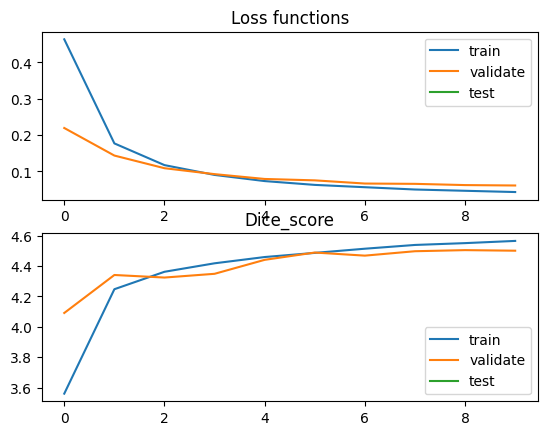

In [20]:
plt.subplot(2,1,1)
plt.plot(training_results['train_loss'],label='train')
plt.plot(training_results['validate_loss'],label='validate')
plt.plot(test_results['test_loss'],label='test')
plt.title('Loss functions')
plt.legend() 
plt.savefig('loss.png')
plt.subplot(2,1,2)
plt.plot(training_results['train_dice_score'],label='train')
plt.plot(training_results['validate_dice_score'],label='validate')
plt.plot(test_results['test_dice_score'],label='test')
plt.title('Dice_score')
plt.legend() 
plt.savefig('dice_score.png')

In [ ]:
model=torch.load('/kaggle/working/model1.pth')


In [22]:

def view_predictions(index, data, device):

    path_img=data['image path'][index]
    path_mask=data['mask path'][index]
    predicted_mask,predicted_class=predict(path_img,path_mask,device)
    predicted_mask = predicted_mask.squeeze(0) 
    predicted_class = torch.argmax(predicted_mask, dim=0).cpu().numpy() 
    img=Image.open(path_img)
    img_array=np.array(img).astype(np.float32) / 255
    mask=Image.open(path_mask)
    mask_array=np.array(mask).astype(np.float32) / 255
    plt.figure(figsize=(15, 10))


    plt.subplot(3, 3, 1)
    plt.title('Original Image')
    plt.imshow(img_array, cmap='gray')
    

    plt.subplot(3, 3, 2)
    plt.title('Original Mask')
    plt.imshow(mask_array, cmap='gray')
    

    plt.subplot(3, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(predicted_class, cmap='gray') 
    
    
    plt.subplot(3, 3, 4)
    plt.title(f'Predicted Mask (Class 1)')
    plt.imshow((predicted_class == 0).astype(np.float32), cmap='gray') 
    
    plt.subplot(3, 3, 5)
    plt.title(f'Predicted Mask (Class 2)')
    plt.imshow((predicted_class == 1).astype(np.float32), cmap='gray') 
    
    plt.subplot(3, 3, 6)
    plt.title(f'Predicted Mask (Class 3)')
    plt.imshow((predicted_class == 3).astype(np.float32), cmap='gray') 

    plt.subplot(3, 3, 7)
    plt.title(f'Predicted Mask (Class 4)')
    plt.imshow((predicted_class == 4).astype(np.float32), cmap='gray')  

    plt.subplot(3, 3, 8)
    plt.title(f'Predicted Mask (Class 5)')
    plt.imshow((predicted_class == 5).astype(np.float32), cmap='gray')  

    
    plt.show()

    


In [23]:
def predict(path_img, path_mask, device):
    loss_fn = torch.nn.CrossEntropyLoss()
    test_loss = 0
    test_dice = 0
    

    X = Image.open(path_img)
    y = Image.open(path_mask)

    X = preprocess_image(X).unsqueeze(0)
    y = preprocess_mask(y).unsqueeze(0).long()  
   

    print(f'Image shape {X.shape}, mask shape {y.shape}')
    
    # print(f'Min value in mask: {y.min()}, Max value in mask: {y.max()}, Unique values: {np.unique(y)}')

    class_dice_scores = {i: 0 for i in range(5)}
    with torch.inference_mode():
        X, y = X.to(device), y.to(device)
        

        y_pred = model(X)
        y_pred = y_pred["out"]
        y = y.squeeze(1) 
        

        predicted_class = torch.argmax(y_pred, dim=1) 
        

        eps = 1e-8
        for i in range(1, 5): 
            predicted_class_i = (predicted_class == i).float()
            y_i = (y == i).float()
            print(predicted_class_i.sum(),y_i.sum())

            dice_score = (2 * (y_i * predicted_class_i).sum() + eps) / (y_i.sum() + predicted_class_i.sum() + eps)
            test_dice += dice_score.item()
            class_dice_scores[i] += dice_score.item()

        
        print(f'test_dice: {class_dice_scores}')
    
    return y_pred.cpu(), predicted_class.cpu()


1511
Image shape torch.Size([1, 3, 360, 480]), mask shape torch.Size([1, 360, 480])
tensor(2288., device='cuda:0') tensor(1906., device='cuda:0')
tensor(462., device='cuda:0') tensor(384., device='cuda:0')
tensor(805., device='cuda:0') tensor(700., device='cuda:0')
tensor(157731., device='cuda:0') tensor(162337., device='cuda:0')
test_dice: {0: 0, 1: 0.8884119987487793, 2: 0.9030733108520508, 3: 0.6990033388137817, 4: 0.9855218529701233}


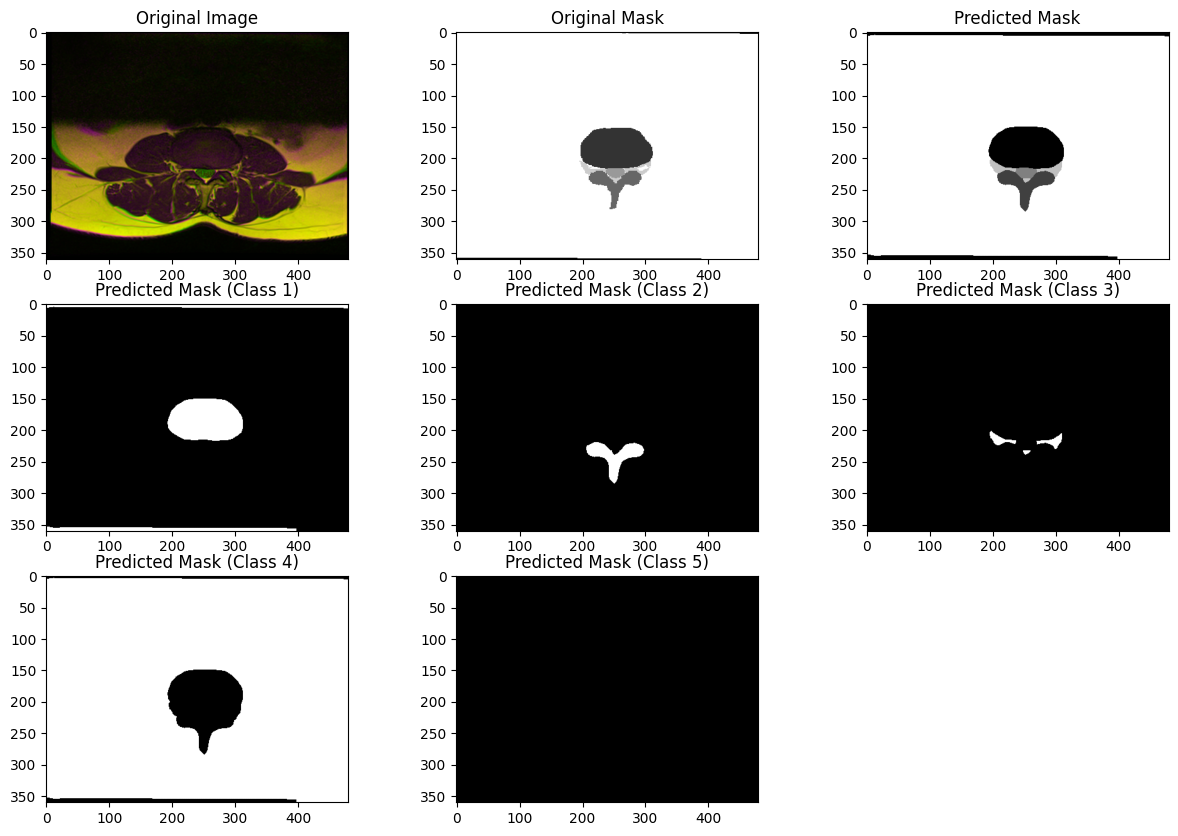

In [24]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)
index=random.randint(0,len(data.index))
print(index)
view_predictions(index=index,data=data,device=DEVICE)

Image shape torch.Size([1, 3, 360, 480]), mask shape torch.Size([1, 360, 480])
tensor(3114., device='cuda:0') tensor(2715., device='cuda:0')
tensor(492., device='cuda:0') tensor(449., device='cuda:0')
tensor(1404., device='cuda:0') tensor(1235., device='cuda:0')
tensor(160881., device='cuda:0') tensor(161897., device='cuda:0')
test_dice: {0: 0, 1: 0.9229713678359985, 2: 0.947927713394165, 3: 0.8328912258148193, 4: 0.9968399405479431}


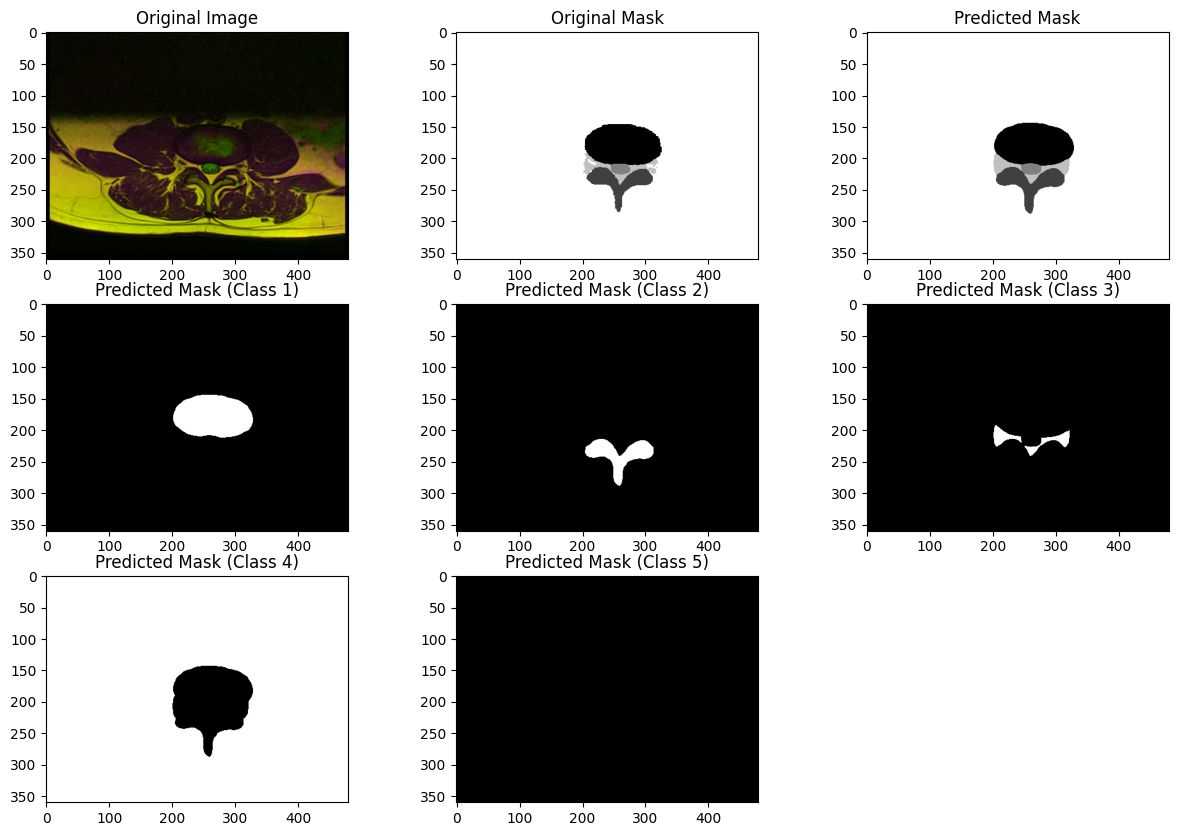

In [25]:
index=random.randint(0,len(data.index))
view_predictions(index=index,data=data,device=DEVICE)

Image shape torch.Size([1, 3, 360, 480]), mask shape torch.Size([1, 360, 480])
tensor(4019., device='cuda:0') tensor(3511., device='cuda:0')
tensor(189., device='cuda:0') tensor(76., device='cuda:0')
tensor(1038., device='cuda:0') tensor(1045., device='cuda:0')
tensor(160939., device='cuda:0') tensor(161670., device='cuda:0')
test_dice: {0: 0, 1: 0.9298804998397827, 2: 0.44528302550315857, 3: 0.7287566065788269, 4: 0.9973373413085938}


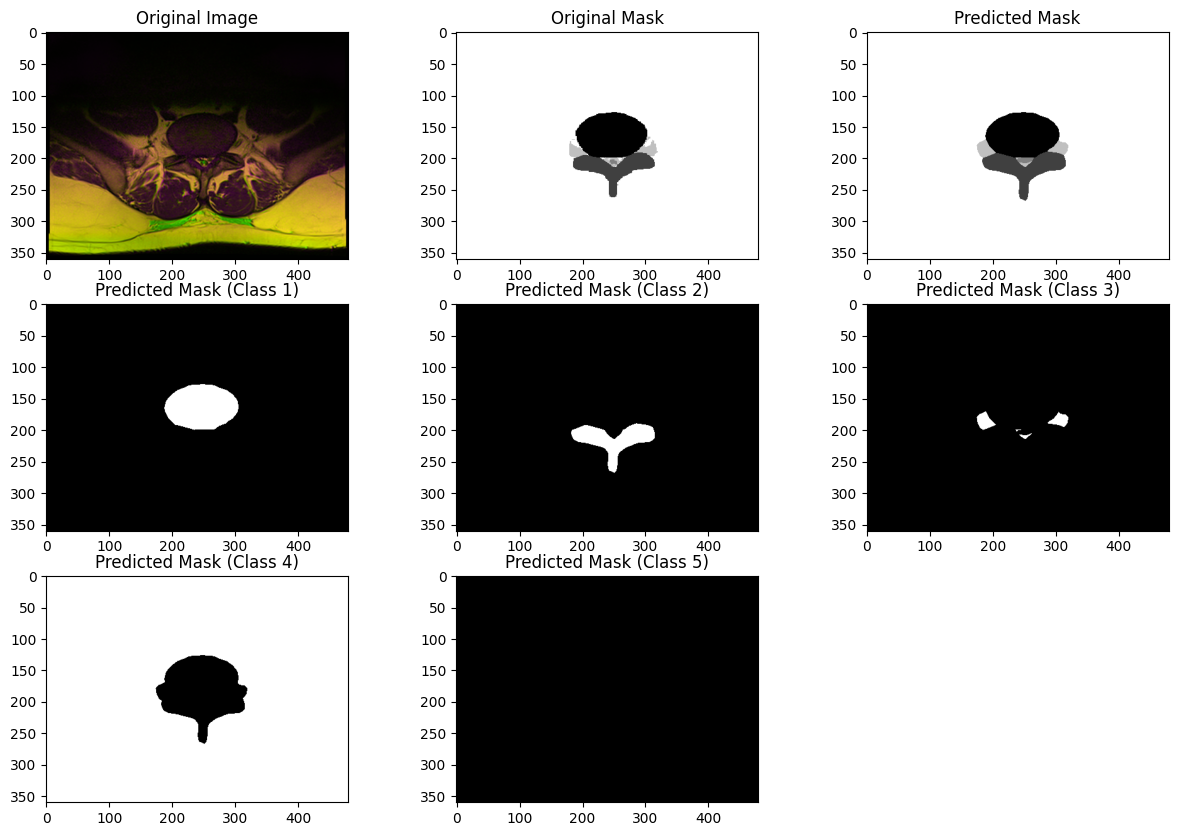

In [26]:
index=random.randint(0,len(data.index))
view_predictions(index=index,data=data,device=DEVICE)

Image shape torch.Size([1, 3, 360, 480]), mask shape torch.Size([1, 360, 480])
tensor(3167., device='cuda:0') tensor(2758., device='cuda:0')
tensor(346., device='cuda:0') tensor(288., device='cuda:0')
tensor(1472., device='cuda:0') tensor(1244., device='cuda:0')
tensor(160640., device='cuda:0') tensor(161711., device='cuda:0')
test_dice: {0: 0, 1: 0.9191561341285706, 2: 0.9085173606872559, 3: 0.7974963188171387, 4: 0.9966216683387756}


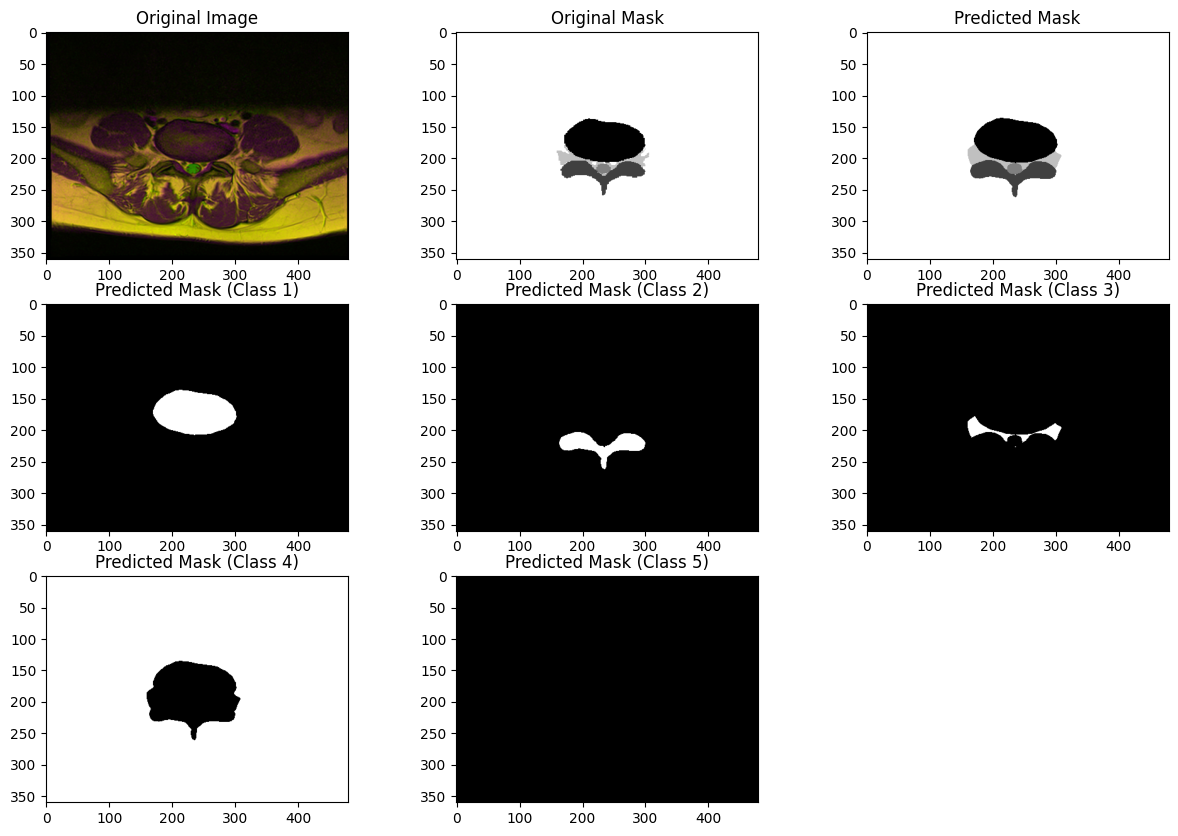

In [27]:
index=random.randint(0,len(data.index))
view_predictions(index=index,data=data,device=DEVICE)

Image shape torch.Size([1, 3, 360, 480]), mask shape torch.Size([1, 360, 480])
tensor(4632., device='cuda:0') tensor(4147., device='cuda:0')
tensor(766., device='cuda:0') tensor(699., device='cuda:0')
tensor(1892., device='cuda:0') tensor(1697., device='cuda:0')
tensor(159174., device='cuda:0') tensor(160301., device='cuda:0')
test_dice: {0: 0, 1: 0.9399703741073608, 2: 0.9242320656776428, 3: 0.8303148746490479, 4: 0.9964034557342529}


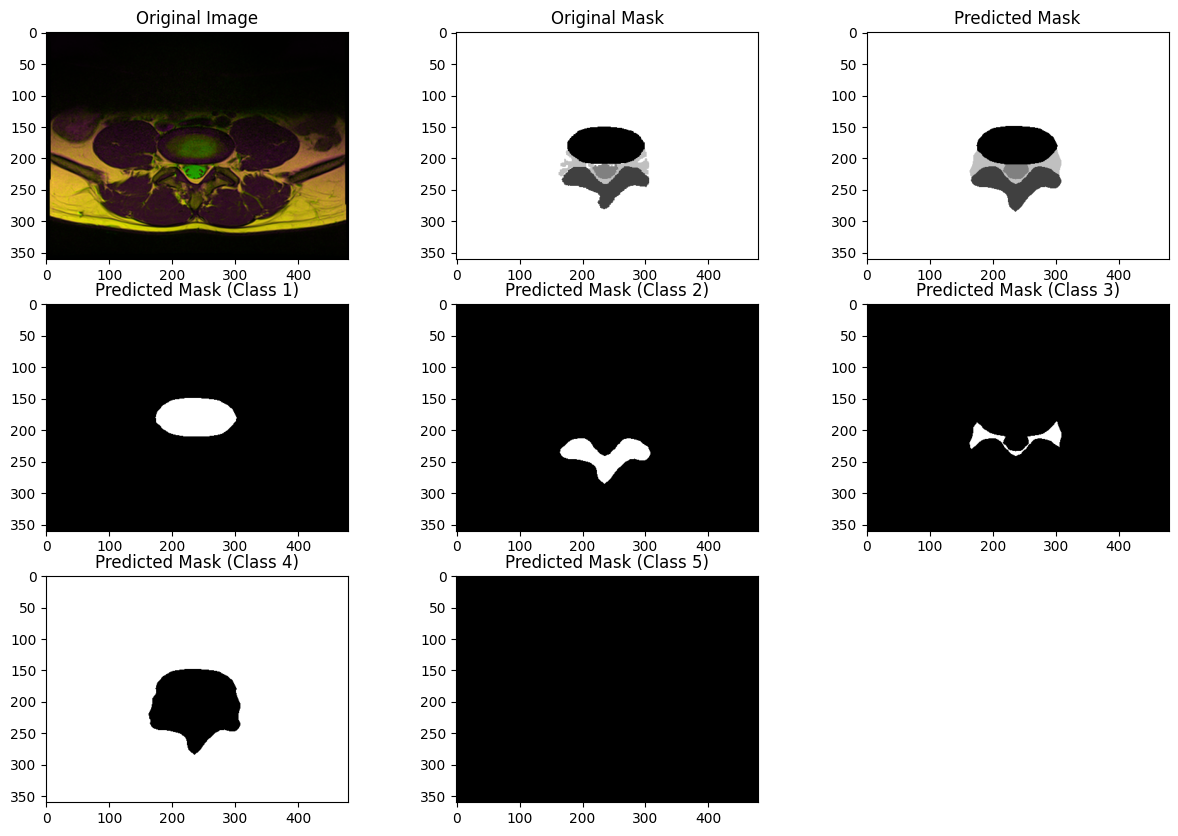

In [28]:
index=random.randint(0,len(data.index))
view_predictions(index=index,data=data,device=DEVICE)

Image shape torch.Size([1, 3, 360, 480]), mask shape torch.Size([1, 360, 480])
tensor(3099., device='cuda:0') tensor(2622., device='cuda:0')
tensor(1087., device='cuda:0') tensor(1074., device='cuda:0')
tensor(1121., device='cuda:0') tensor(991., device='cuda:0')
tensor(161544., device='cuda:0') tensor(162561., device='cuda:0')
test_dice: {0: 0, 1: 0.8984443545341492, 2: 0.9689958095550537, 3: 0.7945075631141663, 4: 0.9965042471885681}


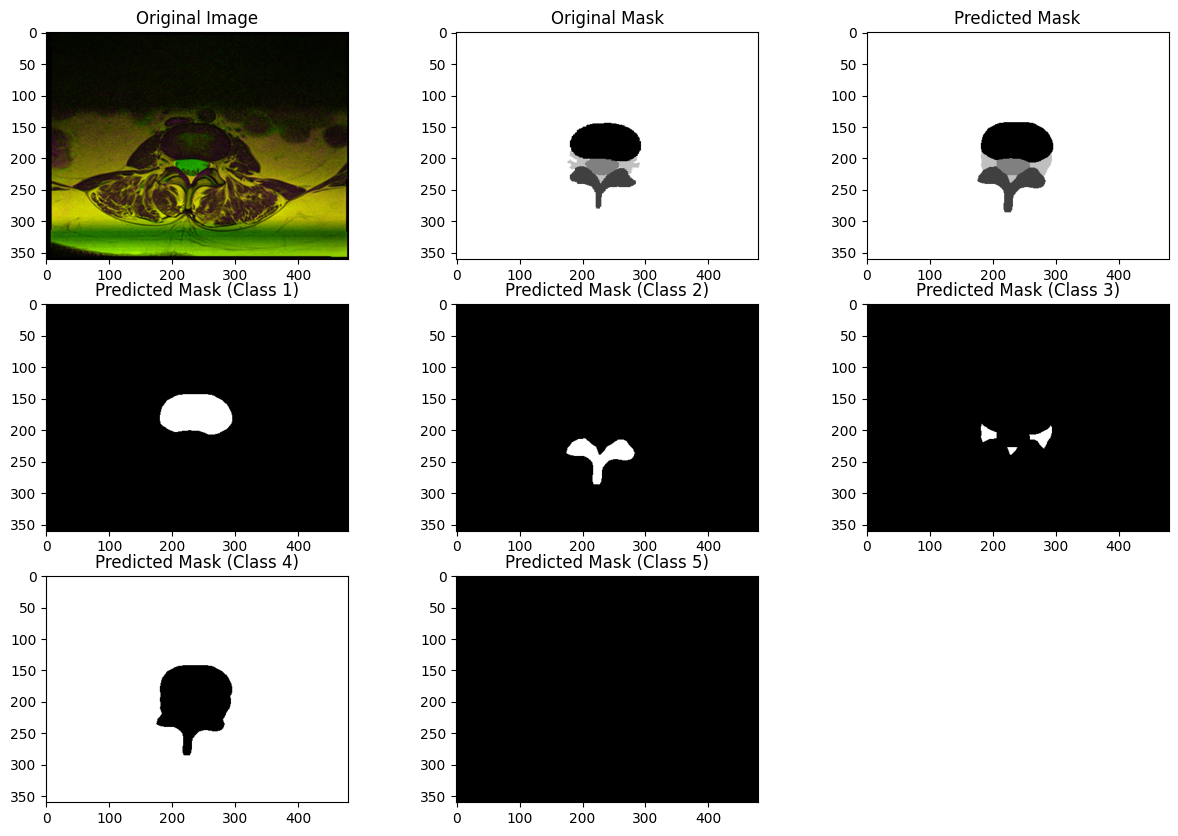

In [29]:
index=random.randint(0,len(data.index))
view_predictions(index=index,data=data,device=DEVICE)